In [5]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
import davemodel
from davemodel import MyLogisticRegression, DaveModelBase
from importlib import reload


In [6]:
men_train = pd.read_csv("_RawData/mens_train_file.csv")
men_test = pd.read_csv("_RawData/mens_test_file.csv")
women_train = pd.read_csv("_RawData/womens_train_file.csv")
women_test = pd.read_csv("_RawData/womens_test_file.csv")


In [7]:
print(men_train.shape)
print(men_test.shape)
print(women_train.shape)
print(women_test.shape)


(5000, 28)
(2000, 28)
(5000, 28)
(1000, 28)


In [8]:
# Analyse data

men_analyse = pd.DataFrame(columns=["Name", "Type", "Unique", "NA"])

for col in men_train.columns:
    men_data = men_train[col]
    men_analyse = men_analyse.append({
        "Name": col, 
        "Type": men_data.dtype, 
        "Unique": men_data.nunique(), 
        "NA": men_data.isnull().sum()
    }, ignore_index=True)

men_analyse.sort_values(by = "Type")

,Name,Type,Unique,NA
23,server.is.impact.player,bool,2,0
20,same.side,bool,2,0
7,outside.sideline,bool,2,0
8,outside.baseline,bool,2,0
0,rally,int64,30,0
1,serve,int64,2,0
25,train,int64,1,0
24,id,int64,5000,0
22,previous.time.to.net,float64,5000,0
19,opponent.distance.from.center,float64,4505,0


In [99]:
def speed_cat(ball_speed):
    speed = ball_speed
    
    if ball_speed > 50:
        speed = 50
    elif ball_speed < 10:
        speed = 10
    
#     if prev_speed < 20:
#         speed = 0
#     elif prev_speed < 25:
#         speed = 1
#     elif prev_speed < 30:
#         speed = 2
#     elif prev_speed < 35:
#         speed = 3
#     elif prev_speed < 40:
#         speed = 4
#     else:
#         speed = 5
        
    return speed

def net_clearance(clearance):
    net = clearance
    
    if clearance > 6:
        net = 6
    
#     if clearance < 0:
#         net = 0
#     elif clearance < 0.5:
#         net = 1
#     elif clearance < 1:
#         net = 2
#     elif clearance < 2:
#         net = 3
#     else:
#         net = 4
        
    return net

def get_rally_length(rally_length):
    rally = rally_length
    
    if rally_length > 15:
        rally = 16
    
#     if rally_length <= 3:
#         rally = 3
#     elif rally_length <= 4:
#         rally = 4
#     elif rally_length <= 5:
#         rally = 5
#     elif rally_length <= 6:
#         rally = 6
#     elif rally_length <= 8:
#         rally = 8
#     elif rally_length <= 11:
#         rally = 11
#     elif rally_length <= 15:
#         rally = 15
#     else:
#         rally = 20
        
    return rally
        

def get_distance_from_line(dist, outside):
    if outside == True:
        dist *= -1
#     distance = 0
    
#     if dist < 1:
#         distance = 1
#     elif dist < 2:
#         distance = 2
#     elif dist < 3:
#         distance = 3
#     elif dist < 4:
#         distance = 4
#     else:
#         distance = 5
    return dist

In [201]:

        
# Remove unneeded columns
def process_data(data, gender):
    ids = data["id"].apply(lambda x: str(x) + "_" + gender)

    cat_cols = ["easy.shot", "hard.shot", "server.is.impact.player", "same.side", "outside.baseline", "outside.sideline", "serve", "hitpoint", "previous.hitpoint"]
#     cat_cols += ["net.clearance.group", "prev.speed.group", "speed.group", "rally.group"]
    drop_cols = ["id", "train", "gender", "outcome"]
    drop_cols += ["previous.speed", "speed", "net.clearance", "rally"]
    drop_cols += ["distance.from.sideline", "depth"]
    drop_cols += cat_cols
    num_cols = [x for x in data.columns.tolist() if x not in drop_cols]
    num_cols += ["distance.from.sideline.group", "depth.group", "net.clearance.group", "prev.speed.group", "speed.group", "rally.group"]

    print(len(cat_cols) + len(drop_cols) + len(num_cols))
    
    new_data = data.copy()
    
    new_data["prev.speed.group"] = new_data["previous.speed"].apply(lambda x: speed_cat(x))
    new_data["speed.group"] = new_data["speed"].apply(lambda x: speed_cat(x))
    new_data["net.clearance.group"] = new_data["net.clearance"].apply(lambda x: net_clearance(x))
    new_data["rally.group"] = new_data["rally"].apply(lambda x: get_rally_length(x))
    new_data["distance.from.sideline.group"] = new_data.apply(lambda x: get_distance_from_line(x["distance.from.sideline"], x["outside.sideline"]), axis = 1)
    new_data["depth.group"] = new_data.apply(lambda x: get_distance_from_line(x["depth"], x["outside.baseline"]), axis = 1)
    
    new_data["easy.shot"] = ((new_data["previous.speed"] < 30)
    & (new_data["opponent.distance.from.center"] > 2)
    & (new_data["previous.depth"] > 3)
    & (new_data["player.impact.depth"] < 10)
    & (new_data["previous.net.clearance"] > 1)
    & (new_data["outside.sideline"] == False) 
    & (new_data["outside.baseline"] == False)
    & (new_data["net.clearance"] > 0))
    
    new_data["hard.shot"] = ((new_data["previous.speed"] > 35)
        & ((new_data["previous.depth"] < 1)
        | (new_data["previous.distance.from.sideline"] < 1))
        & (new_data["previous.net.clearance"] < 1)
        & (new_data["player.distance.travelled"] > 3))
    
    new_data = pd.get_dummies(new_data, columns = cat_cols)
    
    for col in drop_cols:
        if new_data.columns.contains(col):
            new_data = new_data.drop([col], axis = 1)
            
    new_data[num_cols] = (new_data[num_cols] - new_data[num_cols].mean()) / new_data[num_cols].std()


            
    return ids, new_data

    
def get_train_data(data, gender):
    new_label = data["outcome"]
    ids, new_data = process_data(data, gender)

    return ids, new_data, new_label

men_ids, X_men, y_men = get_train_data(men_train, "mens")
women_ids, X_women, y_women = get_train_data(women_train, "womens")

men_test_ids, X_men_test = process_data(men_test, "mens")
women_test_ids, X_women_test = process_data(women_test, "womens")

print(X_men.shape)
print(y_men.shape)
print(X_women.shape)
print(y_women.shape)
print(X_men_test.shape)
print(X_women_test.shape)


45
45
45
45
(5000, 39)
(5000,)
(5000, 39)
(5000,)
(2000, 39)
(1000, 39)


In [183]:
pd.options.display.max_columns = 50
pd.options.display.max_rows = 1000
# X_men[X_men["easy.shot"] == True].shape
X_men.head()

,player.distance.travelled,player.impact.depth,player.impact.distance.from.center,player.depth,player.distance.from.center,previous.net.clearance,previous.distance.from.sideline,previous.depth,opponent.depth,opponent.distance.from.center,previous.time.to.net,prev.speed.group,speed.group,net.clearance.group,rally.group,distance.from.sideline.group,depth.group,easy.shot_False,easy.shot_True,server.is.impact.player_False,server.is.impact.player_True,same.side_False,same.side_True,outside.baseline_False,outside.baseline_True,outside.sideline_False,outside.sideline_True,serve_1,serve_2,hitpoint_B,hitpoint_F,hitpoint_U,hitpoint_V,previous.hitpoint_B,previous.hitpoint_F,previous.hitpoint_U,previous.hitpoint_V
0,-0.808756,0.762886,-0.738909,0.612054,-1.042314,0.852426,0.330016,-1.699856,-0.018598,-0.292499,-0.516968,0.455623,0.535812,-0.648047,-0.592564,1.644337,0.713994,1,0,1,0,0,1,1,0,1,0,1,0,1,0,0,0,0,1,0,0
1,-0.345224,0.300325,2.056659,0.166630,0.948868,-0.068022,-1.458892,-0.217178,-0.107019,1.965721,-0.584499,0.705395,0.272785,0.487686,-0.592564,0.984461,-1.731546,1,0,1,0,1,0,0,1,1,0,0,1,1,0,0,0,1,0,0,0
2,0.528630,1.150147,-0.506976,0.624626,0.733424,-0.665135,-0.948881,-0.663091,0.532636,-0.601518,-0.767404,1.526797,-1.092171,-0.880329,3.022102,1.685599,1.399877,1,0,0,1,1,0,1,0,1,0,1,0,1,0,0,0,0,1,0,0
3,-1.293952,0.619564,-1.633234,0.387663,-1.247052,0.678488,1.104211,-1.769436,0.701332,-1.712651,0.671082,-0.587208,0.698910,0.140237,0.913547,-1.225350,-0.184382,1,0,0,1,0,1,1,0,0,1,1,0,0,1,0,0,1,0,0,0
4,-0.333407,1.092496,-0.245167,0.810355,-0.963936,-0.995855,-0.646018,-0.175435,-0.526469,-1.008740,-1.066828,1.095692,0.539409,-0.510184,-0.592564,-0.161588,0.376398,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,0,0,1,0,0


In [151]:
blah = X_men.copy()
blah["outcome"] = y_men
blah = pd.get_dummies(blah, columns=["outcome"])
blah.head(20)
blah.corr()

,player.distance.travelled,player.impact.depth,player.impact.distance.from.center,player.depth,player.distance.from.center,previous.net.clearance,previous.distance.from.sideline,previous.depth,opponent.depth,opponent.distance.from.center,previous.time.to.net,prev.speed.group,speed.group,net.clearance.group,rally.group,distance.from.sideline.group,depth.group,server.is.impact.player_False,server.is.impact.player_True,same.side_False,same.side_True,outside.baseline_False,outside.baseline_True,outside.sideline_False,outside.sideline_True,serve_1,serve_2,hitpoint_B,hitpoint_F,hitpoint_U,hitpoint_V,previous.hitpoint_B,previous.hitpoint_F,previous.hitpoint_U,previous.hitpoint_V,outcome_FE,outcome_UE,outcome_W
player.distance.travelled,1.000000,-0.134047,0.294719,0.127576,0.355950,0.102187,-0.359701,0.177111,-0.188873,-0.140693,0.234549,-0.318200,-0.125458,-0.030984,0.088288,-0.036704,0.045362,0.149937,-0.149937,-0.178228,0.178228,0.044804,-0.044804,0.002487,-0.002487,0.046561,-0.046561,-0.065098,0.033031,0.032941,0.046667,-0.034488,0.005166,0.019137,0.032133,0.217453,-0.246885,0.061733
player.impact.depth,-0.134047,1.000000,0.252170,0.770338,0.132567,-0.276152,-0.205404,-0.659038,-0.041874,-0.157540,-0.535521,0.536033,0.338016,0.151301,0.074041,-0.072238,-0.135302,0.225394,-0.225394,0.153260,-0.153260,-0.172858,0.172858,-0.141772,0.141772,-0.104412,0.104412,0.056982,-0.005377,-0.118974,0.040334,0.069078,0.362330,0.064657,-0.723755,0.210401,0.205471,-0.404846
player.impact.distance.from.center,0.294719,0.252170,1.000000,0.325930,0.075433,-0.071158,-0.600341,-0.035067,-0.054477,-0.011844,-0.047258,0.074209,0.099438,0.007870,0.118815,-0.085507,-0.047498,0.118757,-0.118757,0.037436,-0.037436,-0.050160,0.050160,-0.086894,0.086894,-0.012752,0.012752,0.070007,-0.061267,-0.023502,0.020335,0.062912,0.098296,0.033281,-0.275601,0.148927,-0.000597,-0.133878
player.depth,0.127576,0.770338,0.325930,1.000000,0.181473,-0.286338,-0.215303,-0.384851,-0.073772,-0.193446,-0.289811,0.311189,0.311374,0.080599,0.191219,-0.088087,-0.135802,0.301621,-0.301621,0.120505,-0.120505,-0.133991,0.133991,-0.113796,0.113796,-0.068204,0.068204,0.077084,-0.024404,-0.115392,0.032339,0.090187,0.317172,0.048439,-0.673995,0.132350,0.163285,-0.290248
player.distance.from.center,0.355950,0.132567,0.075433,0.181473,1.000000,-0.047023,-0.063689,-0.092064,-0.190374,-0.076790,-0.062720,-0.089531,-0.013833,0.013557,0.147930,-0.034149,-0.001826,0.247636,-0.247636,-0.012126,0.012126,-0.022976,0.022976,-0.021854,0.021854,-0.009802,0.009802,0.000605,-0.000443,-0.023568,0.042814,0.068947,0.016801,0.021818,-0.148356,0.124476,-0.063954,-0.045554
previous.net.clearance,0.102187,-0.276152,-0.071158,-0.286338,-0.047023,1.000000,0.105220,-0.149373,0.197372,0.106095,0.566784,-0.410126,0.255812,-0.045601,-0.053163,0.013008,0.027074,-0.157044,0.157044,-0.050163,0.050163,0.096106,-0.096106,0.070564,-0.070564,0.051697,-0.051697,-0.157153,0.094593,0.125221,-0.024673,-0.050257,-0.126308,-0.022022,0.292505,-0.228020,-0.063658,0.272490
previous.distance.from.sideline,-0.359701,-0.205404,-0.600341,-0.215303,-0.063689,0.105220,1.000000,0.126252,0.138495,0.094787,0.197494,-0.166266,0.153497,-0.073218,-0.158097,0.018525,-0.022361,-0.178170,0.178170,0.041843,-0.041843,0.058052,-0.058052,0.087184,-0.087184,0.003062,-0.003062,-0.233633,0.243495,0.001698,-0.066952,0.090960,-0.137321,0.002463,0.074272,-0.347894,0.139241,0.168619
previous.depth,0.177111,-0.659038,-0.035067,-0.384851,-0.092064,-0.149373,0.126252,1.000000,0.079619,0.084795,0.416619,-0.308147,-0.182619,-0.157565,-0.034678,0.032412,0.071671,-0.117495,0.117495,-0.095015,0.095015,0.117328,-0.117328,0.095988,-0.095988,0.077644,-0.077644,-0.011259,-0.005363,0.053802,-0.040586,-0.090876,-0.140526,-0.046335,0.394601,-0.165539,-0.118912,0.273830
opponent.depth,-0.188873,-0.041874,-0.054477,-0.073772,-0.190374,0.197372,0.138495,0.079619,1.000000,0.180199,0.421553,0.317925,0.162122,-0.119373,0.058970,0.038354,0.015815,-0.213093,0.213093,0.045883,-0.04588

In [11]:
men_train[men_train["net.clearance"] < 0]["outcome"].value_counts()

UE    860
FE    536
W      30
Name: outcome, dtype: int64

In [12]:
men_train["player.impact.distance.from.center"].max()

7.7462

In [13]:
# men_train[(men_train["net.clearance"] < -0.04)]

In [14]:
men_train["outcome"].value_counts()

UE    2118
W     1684
FE    1198
Name: outcome, dtype: int64

In [15]:
men_train[(men_train["outside.sideline"] == True)]["outcome"].value_counts()

UE    625
FE    337
W       4
Name: outcome, dtype: int64

In [16]:
men_train[(men_train["outside.baseline"] == True)]["outcome"].value_counts()

UE    639
FE    315
W      15
Name: outcome, dtype: int64

In [17]:
men_train[(men_train["outside.sideline"] == True) & (men_train["outside.baseline"] == True)]["outcome"].value_counts()

UE    101
FE     55
W       2
Name: outcome, dtype: int64

In [18]:
men_train.shape

(5000, 28)

In [19]:
men_train[(men_train["outside.sideline"] == False) & (men_train["outside.baseline"] == False)]["outcome"].value_counts()

W     1667
UE     955
FE     601
Name: outcome, dtype: int64

In [20]:
men_train[(men_train["outside.sideline"] == False) & (men_train["outside.baseline"] == False) & (men_train["net.clearance"] > 0)]["outcome"].value_counts()

W     1639
UE     131
FE     111
Name: outcome, dtype: int64

In [21]:
# men_train[(men_train["outside.sideline"] == False) & (men_train["outside.baseline"] == False) & (men_train["net.clearance"] > 0)]

In [22]:
# men_train[(men_train["outside.sideline"] == False) & (men_train["outside.baseline"] == False) & (men_train["net.clearance"] > 0) & (men_train["outcome"] != "W")]

In [23]:
men_train[
    (men_train["outside.sideline"] == False) 
    & (men_train["outside.baseline"] == False) 
    & (men_train["net.clearance"] > 0)
#     & ((men_train["distance.from.sideline"] < 0.02) == False)
#     & ((men_train["depth"] < 0.02) == False)
]["outcome"].value_counts()

W     1639
UE     131
FE     111
Name: outcome, dtype: int64

In [24]:
men_train[
    men_train["hitpoint"] == "U"
]["outcome"].value_counts()

W     139
FE    106
UE    104
Name: outcome, dtype: int64

In [25]:
# Potential features
# Good shot
# Bad shot
# Easy shot
# Hard shot

In [26]:
men_train[
    (men_train["previous.speed"] < 30)
    & (men_train["opponent.distance.from.center"] > 2)
    & (men_train["previous.depth"] > 3)
    & (men_train["previous.net.clearance"] > 1)
    & (men_train["outside.sideline"] == False) 
    & (men_train["outside.baseline"] == False)
    & (men_train["net.clearance"] > 0)
#     & (men_train["depth"] > 0.2)
#     & (men_train["distance.from.sideline"] > 0.2)
#     & (men_train["player.distance.travelled"] < 4)
#     & (men_train["player.distance.from.center"] < 1)
#     & (men_train["hitpoint"] != "F")
]["outcome"].value_counts()

W     364
UE      3
Name: outcome, dtype: int64

In [27]:
men_train[
    (men_train["outside.sideline"] == False) 
    & (men_train["outside.baseline"] == False)
    & (men_train["net.clearance"] > 0)
#     & (men_train["depth"] > 0.2)
#     & (men_train["distance.from.sideline"] > 0.2)
#     & (men_train["player.distance.travelled"] < 4)
#     & (men_train["player.distance.from.center"] < 1)
#     & (men_train["hitpoint"] != "F")
]["outcome"].value_counts()

W     1639
UE     131
FE     111
Name: outcome, dtype: int64

In [120]:
men_train[pd.isnull(men_train["net.clearance"])]

,rally,serve,hitpoint,speed,net.clearance,distance.from.sideline,depth,outside.sideline,outside.baseline,player.distance.travelled,player.impact.depth,player.impact.distance.from.center,player.depth,player.distance.from.center,previous.speed,previous.net.clearance,previous.distance.from.sideline,previous.depth,opponent.depth,opponent.distance.from.center,same.side,previous.hitpoint,previous.time.to.net,server.is.impact.player,id,train,outcome,gender


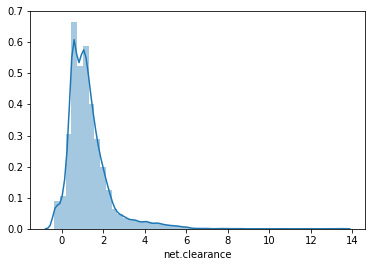

In [138]:
import seaborn as sns
%matplotlib inline
blah = men_train["net.clearance"] + men_train["net.clearance"].mean()
sns.distplot(blah)
# sns.distplot(np.log(blah))
# sns.distplot(men_train["net.clearance"])
# men_train["previous.speed"] < 30
# sns.regplot(men_train["previous.speed"], men_train["outcome"])

In [29]:
# men_train[(men_train["previous.speed"] < 25) & (men_train["outcome"] == "UE")]

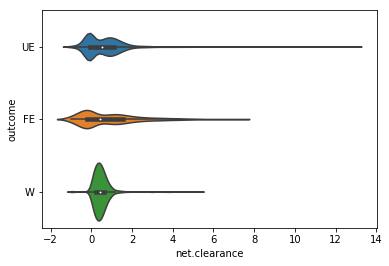

In [98]:
sns.violinplot(men_train["net.clearance"], men_train["outcome"])

In [31]:
men_train[(men_train["rally"] < 4) & (men_train["server.is.impact.player"] == True)]["outcome"].value_counts()

UE    589
W     549
FE    181
Name: outcome, dtype: int64

In [32]:
men_train[
    (men_train["previous.speed"] > 35)
    & ((men_train["previous.depth"] < 1)
    | (men_train["previous.distance.from.sideline"] < 1))
    & (men_train["previous.net.clearance"] < 1)
    & (men_train["player.distance.travelled"] > 3)
]["outcome"].value_counts()

FE    125
UE     18
W      13
Name: outcome, dtype: int64

In [172]:
men_train[
    (men_train["player.impact.depth"] < 10)
    & (men_train["previous.speed"] < 25)
    & (men_train["previous.net.clearance"] > 1)
#     & ((men_train["previous.depth"] < 1)
#     | (men_train["previous.distance.from.sideline"] < 1))
#     & (men_train["previous.net.clearance"] < 1)
#     & (men_train["player.distance.travelled"] > 3)
]["outcome"].value_counts()

W     308
UE     48
FE      7
Name: outcome, dtype: int64

In [181]:
men_train[   
(men_train["previous.speed"] < 30)
    & (men_train["opponent.distance.from.center"] > 2)
    & (men_train["player.impact.depth"] < 10)
    & (men_train["previous.depth"] > 3)
    & (men_train["previous.net.clearance"] > 1)
    & (men_train["outside.sideline"] == False) 
    & (men_train["outside.baseline"] == False)
    & (men_train["net.clearance"] > 0)
]["outcome"].value_counts()

W    243
Name: outcome, dtype: int64

In [199]:
men_train[   
(men_train["previous.speed"] > 35)
    & (men_train["opponent.distance.from.center"] < 2)
    & (men_train["player.impact.depth"] > 10)
    & (men_train["previous.depth"] < 2.5)
    & (men_train["previous.net.clearance"] < 1)
#     & (men_train["outside.sideline"] == False) 
#     & (men_train["outside.baseline"] == False)
#     & (men_train["net.clearance"] > 0)
]["outcome"].value_counts()

FE    75
UE    38
W     10
Name: outcome, dtype: int64

In [200]:
men_train[
    (men_train["previous.speed"] > 35)
    & ((men_train["previous.depth"] < 1)
    | (men_train["previous.distance.from.sideline"] < 1))
    & (men_train["previous.net.clearance"] < 1)
    & (men_train["player.distance.travelled"] > 3)
]["outcome"].value_counts()

FE    125
UE     18
W      13
Name: outcome, dtype: int64

In [202]:
reload(davemodel)
from davemodel import MyLogisticRegression, MyRandomForest, MyXGBoost, MyBagging, MyGradientBoosting


In [203]:
xgb = MyXGBoost(men_test_ids, X_men, y_men, X_men_test, women_test_ids, X_women, y_women, X_women_test)

In [204]:
xgb.run()


Training men...
Log loss: 0.0538411583272

Training women...
Log loss: 0.0619103410183

Predicting men...
Prediction count: (2000, 3)

Predicting women...
Prediction count: (1000, 3)

Evaluating men...
Log loss: 0.33739072774

Evaluating women...
Log loss: 0.3225814242

Creating submission...
Submission created

Saving model to XGBoost.pickle ...
Saved


Training men...
Log loss: 0.0655140158704

Training women...
Log loss: 0.0717281517376

Evaluating men...
Log loss: 0.347882771873

Evaluating women...
Log loss: 0.322999404865

After rally processing...

Training men...
Log loss: 0.0654222273353

Training women...
Log loss: 0.0711783661127

Evaluating men...
Log loss: 0.347743090316

Evaluating women...
Log loss: 0.323896772858

After rally processing (group)...

Training men...
Log loss: 0.0663863809005

Training women...
Log loss: 0.0722016647023

Evaluating men...
Log loss: 0.347103495116

Evaluating women...
Log loss: 0.326249558927

Ater simplifying...

Training men...
Log loss: 0.0533030387483

Training women...
Log loss: 0.0611690153603

Evaluating men...
Log loss: 0.335717847113

Evaluating women...
Log loss: 0.324973114222

In [443]:
xgb.evaluate()

Log loss: 0.347882771873
Log loss: 0.322999404865


In [446]:
pred_men, pred_women = xgb.predict()


Predicting men...
Prediction count: (2000, 3)

Predicting women...
Prediction count: (1000, 3)


In [447]:
xgb.create_submission(pred_men, pred_women)

Creating submission...
Done!


In [299]:
forest = MyRandomForest(men_test_ids, X_men, y_men, X_men_test, women_test_ids, X_women, y_women, X_women_test)

In [300]:
forest.run()


Training men...
Log loss: 0.113053191619

Training women...
Log loss: 0.115107020642

Predicting men...
Prediction count: (2000, 3)

Predicting women...
Prediction count: (1000, 3)
Creating submission...
Done!
Saved


In [301]:
# forest.evaluate
forest.model_men.best_params_

{'max_depth': 13, 'max_features': 10, 'n_estimators': 60}

In [302]:
forest.model_women.best_params_

{'max_depth': 13, 'max_features': 20, 'n_estimators': 60}

In [303]:
forest.evaluate()

Log loss: 0.381428495174
Log loss: 0.357969562564
